In [14]:
#  to get automatic reloading
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.plots import *
from fastai.io import get_data
from fastai.conv_learner import *

In [15]:
PATH = "data/emotionet/"
IMGP = "imgs"
csv_path = f"{PATH}uniqueaus6_12.csv"

In [16]:
n = len(list(open(csv_path)))-1
val_idxs = get_cv_idxs(n)
n, len(val_idxs)

(355, 71)

In [17]:
sz = 224
f_model = resnet34
bs = 64

In [5]:
arch=resnet34
tfms = tfms_from_model(f_model, sz)
data = ImageClassifierData.from_csv(PATH, IMGP, csv_path, tfms=tfms, val_idxs=val_idxs)
learn = ConvLearner.pretrained(arch, data, precompute=True)
# learn.fit(0.01, 2)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

**check where is looking the model**

In [18]:
arch=resnet34
m = arch(True)

In [19]:
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [20]:
m = nn.Sequential(*children(m)[:-2],
                 nn.Conv2d(512,2,3,padding=1),
                 nn.AdaptiveAvgPool2d(1), Flatten(),
                 nn.LogSoftmax())

In [9]:
m

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [21]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, IMGP, csv_path, tfms=tfms, bs=bs)

In [22]:
learn = ConvLearner.from_model_data(m, data)

In [23]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

In [24]:
learn.freeze_to(-4)

In [25]:
m[-1].trainable

True

In [26]:
m[-4].trainable

True

In [27]:
learn.fit(0.01,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      10.722246  11.066055  0.56338   



[array([11.06605]), 0.5633802816901409]

In [28]:
learn.fit(0.01, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      9.5631     9.717884   0.450704  



[array([9.71788]), 0.4507042253521127]

In [29]:
learn.fit(0.01, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      13.938133  18.598593  0.56338   
    1      12.313262  12.14951   0.56338                
    2      12.444238  21.979798  0.591549               



[array([21.9798]), 0.5915492957746479]

In [30]:
learn.fit(1e-4, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      16.965307  20.769745  0.591549  



[array([20.76974]), 0.5915492957746479]

In [31]:
learn.precompute=False

In [32]:
learn.fit(1e-4,3,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      16.61347   20.310314  0.605634  
    1      15.907167  18.969876  0.619718               
    2      15.161419  17.239859  0.605634               



[array([17.23986]), 0.6056338028169014]

In [43]:
learn.fit(1e-4,10,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy               
    0      1.612308   9.764333   0.521127  
    1      1.661935   1.651723   0.535211               
    2      1.62088    1.239823   0.549296               
    3      1.457321   1.208179   0.549296               
    4      1.33633    1.204086   0.549296               
    5      1.285691   1.214285   0.56338                
    6      1.193286   1.165071   0.591549               
    7      1.143828   1.078673   0.577465               
    8      1.079348   1.053125   0.535211               
    9      1.046163   1.006897   0.56338                



[array([1.0069]), 0.5633802842086469]

In [44]:
learn.save('224_all')

In [45]:
learn.fit(1e-4,10,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.864341   0.997565   0.535211  
    1      0.819192   0.933921   0.549296                
    2      0.791425   0.924507   0.549296                
    3      0.743455   0.882119   0.605634                
    4      0.753265   0.885447   0.605634                
    5      0.760442   0.904116   0.619718                
    6      0.755939   0.893132   0.605634                
    7      0.730819   0.850558   0.577465                
    8      0.72879    0.83849    0.577465                
    9      0.724612   0.84338    0.577465                



[array([0.84338]), 0.5774647891521454]

In [46]:
learn.save('224_all');
learn.fit(1e-4,10,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.674663   0.83429    0.591549  
    1      0.705897   0.853727   0.591549                
    2      0.727069   0.861315   0.591549                
    3      0.720123   0.822414   0.591549                
    4      0.718272   0.809798   0.619718                
    5      0.710244   0.80268    0.605634                
    6      0.712789   0.846162   0.605634                
    7      0.718003   0.830377   0.605634                
    8      0.712089   0.785805   0.591549                
    9      0.697812   0.778355   0.577465                



[array([0.77836]), 0.5774647899916474]

In [53]:
learn.save('224_all');
learn.fit(1e-4,10,cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                
    0      0.663333   0.741102   0.605634  
    1      0.641561   0.720966   0.591549                
    2      0.64873    0.711515   0.577465                
    3      0.643607   0.732182   0.591549                
    4      0.647778   0.725242   0.591549                
    5      0.643912   0.716146   0.591549                
    6      0.639066   0.688971   0.577465                
    7      0.637139   0.683389   0.577465                
    8      0.639549   0.673834   0.591549                
    9      0.640482   0.70317    0.591549                



[array([0.70317]), 0.5915492964042744]

**paranthesis** just to visualise check the results

In [130]:
learn.save('224_all');

In [54]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.5633802816901409

[[30 10]
 [21 10]]


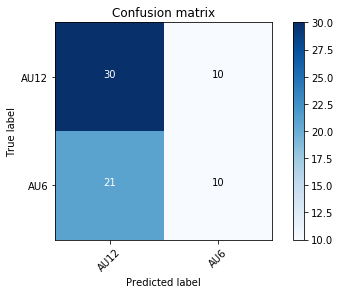

In [55]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [56]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook=m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [157]:
x,y = next(iter(data.val_dl))

In [158]:
idx = 38
x,y = x[None,idx], y[None,idx];y


 0
[torch.cuda.LongTensor of size 1 (GPU 0)]

In [159]:
vx = Variable(x.cuda(), requires_grad=True)

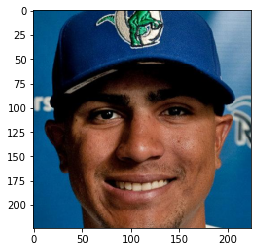

In [160]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx)

In [161]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [175]:
%time py = m(Variable(x.cuda()))

CPU times: user 5.81 ms, sys: 12.4 ms, total: 18.2 ms
Wall time: 17.2 ms


In [177]:
py

Variable containing:
-0.0191 -3.9691
[torch.cuda.FloatTensor of size 1x2 (GPU 0)]

In [164]:
for o in sfs: o.remove()

In [165]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [178]:
py = np.exp(to_np(py)[0])
py

array([0.98111, 0.01889], dtype=float32)

In [179]:
np.argmax(py)

0

In [167]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
# aa = np.rollaxis(feat,0,3)
# feat.shape, aa.shape

In [180]:
f2 = np.dot(np.rollaxis(feat,0,3), py)
f2 -= f2.min()
f2 /= f2.max()
f2

array([[0.05273, 0.19716, 0.35806, 0.18974, 0.05427, 0.00024, 0.00028],
       [0.14313, 0.53995, 1.     , 0.95692, 0.6038 , 0.25263, 0.02692],
       [0.11855, 0.45837, 0.91364, 0.98696, 0.75897, 0.35665, 0.07541],
       [0.0463 , 0.20539, 0.47484, 0.49909, 0.3685 , 0.20845, 0.03687],
       [0.     , 0.04245, 0.16187, 0.1683 , 0.13201, 0.04936, 0.00049],
       [0.00019, 0.     , 0.01477, 0.02427, 0.02934, 0.00562, 0.00007],
       [0.00012, 0.     , 0.02512, 0.0154 , 0.05012, 0.08199, 0.04529]], dtype=float32)

/home/sohaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


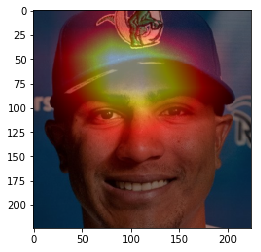

In [181]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot')

In [105]:
idx = 0
py1 = py*0
py1[idx]=1

f2 = np.dot(np.rollaxis(feat,0,3), py1)
f2 -= f2.min()
f2 /= f2.max()
f2

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

/home/sohaib/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


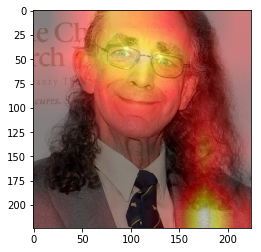

In [90]:
# idx = 0
# py1 = py*0
# py1[idx]=1

# f2 = np.dot(np.rollaxis(feat,0,3), py1)
# f2 -= f2.min()
# f2 /= f2.max()
# print(get_labels_desc(py1))
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot')

In [70]:
classes_description = ['inner_brow_raiser', 'lip_corner_puller', 'chin_raiser', 'outer_brow_raiser', 'lip_stretching', 'lips_part', 'jaw_drop', 'brow_lowerer', 'upper_lid_raiser', 'chick_raiser', 'node_wrinkle']
def get_labels_desc(a): return [classes_description[o] for o in a.nonzero()[0]]

In [89]:
print(get_labels_desc(py1[idx]))

['inner_brow_raiser']
